Standard Imports

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#For debugging, reimport modules when executing cells
%load_ext autoreload
%autoreload 2

# Working with the vectorizer
Import the SmilesVectorizer

In [3]:
from molvecgen import SmilesVectorizer

Work with some molecules

In [4]:
smiles = [ "CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2",
            "CCC[S@@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2"]*10
          
mols =   [Chem.MolFromSmiles(smile) for smile in smiles]

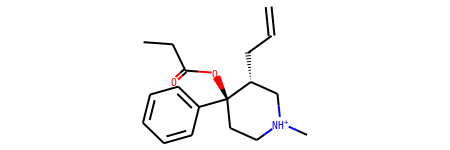

In [5]:
mols[0]

Create the object and fit the characterset and length. The object is called a SMILES vectorizer, but currently only work directly from lists of RDKit molecules. It works by generating the SMILES of the molecule with subsequent one hot encoding into a numpy array. The .fit() function analyses the dataset for which characters are used by the SMILES and updates the character set of the vectorizer as well as adjusting the length of the embedding.

In [6]:
sm_en = SmilesVectorizer(canonical=True, augment=False)

print("Default Charset %s"%sm_en.charset)
print("Default Maximum allowed SMILES length %s"%sm_en.maxlength)

sm_en.fit(mols, extra_chars=["\\"])
print()
print("After fitting")
print("Charset after fit %s"%sm_en.charset)
print("Maximum allowed SMILES length %s"%sm_en.maxlength)


Default Charset @C)(=cOn1S2/H[N]\^$?
Default Maximum allowed SMILES length 120

After fitting
Charset after fit @=]\+/ScH([N2nOC1)^$?
Maximum allowed SMILES length 45


The molecules can be transformed to vectors. The first one is plotted as "piano roll"

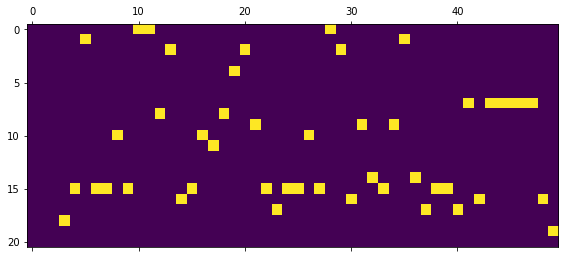

In [7]:
mol_vects = sm_en.transform(mols)
plt.matshow(mol_vects[0].T)

It is also possible to translate the vector back into SMILES as long as the character set is the one that was used to encode the molecule. The start and end tokens are stripped by default, but can be kept if wanted.

In [8]:
#It's possible to strip the start and endchar
sm_en.reverse_transform(mol_vects[0:2])

array(['C=CC[C@@H]1C[NH+](C)CC[C@]1(OC(=O)CC)c1ccccc1',
       'CCC[S@@](=O)c1ccc2[nH]/c(=N\\C(=O)OC)[nH]c2c1'], dtype='<U45')

In [9]:
sm_en.reverse_transform(mol_vects[0:2], strip=False)

array(['^C=CC[C@@H]1C[NH+](C)CC[C@]1(OC(=O)CC)c1ccccc1$',
       '^CCC[S@@](=O)c1ccc2[nH]/c(=N\\C(=O)OC)[nH]c2c1$'], dtype='<U47')

# Combining with the batch generator

In [10]:
from molvecgen import SmilesGenerator

A smilesgenerator used a dataset and a smiles vectorizer as input and returns a generator object.

In [11]:
y=[1,2]*10
#Set data augmentation on
sm_en.augment=True
sm_en.canonical=False

sm_gn = SmilesGenerator(mols,y,sm_en, batch_size=4, shuffle=True)

The next function gives the next batch

In [13]:
batch_x, batch_y = sm_gn.next()
print(batch_x.shape)
print(batch_y.shape)

(4, 50, 21)
(4,)


[2 1 1 2]


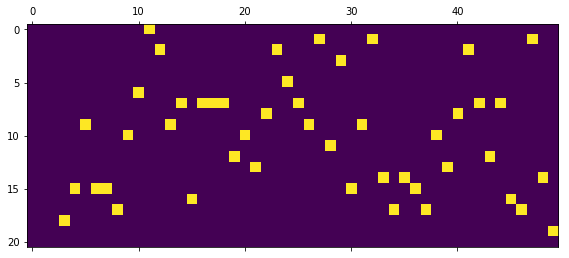

In [14]:
print(batch_y)
plt.matshow(batch_x[0].T)

In a for or while loop it will continue yielding new batches.

In [15]:
for i in range(10):
    batch_x, batch_y = sm_gn.next()
    print(batch_y)

[1 2 1 2]
[2 1 1 1]
[1 1 2 1]
[1 1 1 2]
[2 2 2 1]
[2 1 2 1]
[1 1 1 2]
[2 2 1 2]
[1 1 1 1]
[2 2 2 1]


# Hetero Generator
The heterogenerator is special SMILESgenerator that returns smiles for both input to encoder and teacher forcing the decoder, as well as output from the decoder

In [16]:
from molvecgen.generators import HetSmilesGenerator

In [31]:
#If settings on generator is the same, it can be reused, otherwise recreate
import copy
vect1 = sm_en
vect2 = copy.deepcopy(sm_en)
vect2.augment = False # Set the augment to be false for testing purposes
vect2.leftpad = False # Set the order of the SMILES to be from left to right

print(vect1.augment)
print(vect2.augment) 

True
False


In [32]:
vect2.leftpad

False

In [33]:
batchgen = HetSmilesGenerator(mols, None, vect1, vect2, batch_size=3) #Y is None

In [34]:
_input, _output = batchgen.next()

The first input is one non-canonical form of the SMILES string. The second input and output is another non-canonical SMILES string of the same molecule, offset by a single character.

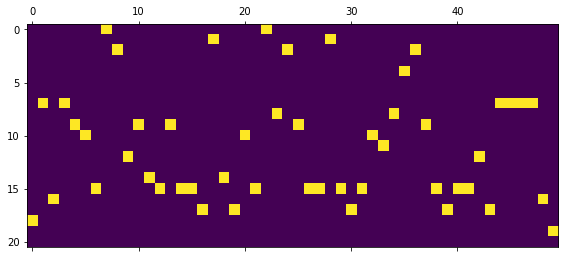

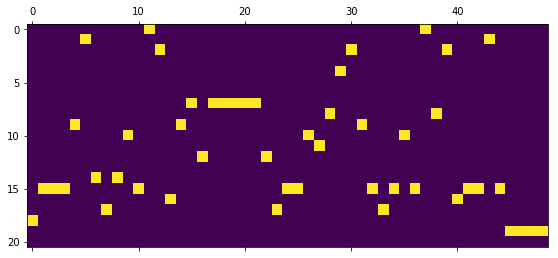

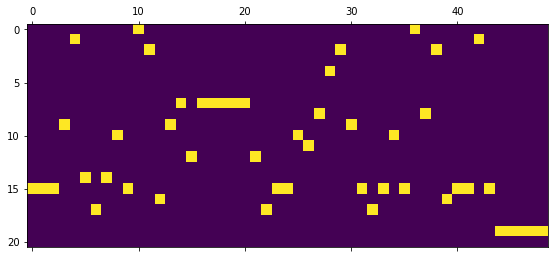

In [35]:
plt.matshow(_input[0][0].T)
plt.matshow(_input[1][0].T)
plt.matshow(_output[0].T)

# Morgan Fingerprints as example of another vectorizer

In [21]:
from molvecgen.vectorizers import MorganDictVectorizer

In [22]:
mdv = MorganDictVectorizer()

In [23]:
#Fit analyses the dataset and set the keys mapping
mdv.fit(mols[0:1])
print(mdv.keys)
mdv.dims

[  98513984  219692797  535847852  864674487  864942730  951226070
 1074692693 1113276223 1275884092 1412710081 1465074879 1471352294
 1510328189 1740632203 1775209781 1963848833 2064788354 2119439498
 2143075994 2154975788 2245384272 2246699815 2246703798 2246728737
 2246997334 2281069397 2534373880 2763854213 2959890341 2968968094
 2976033787 2976816164 3075056557 3116051204 3217380708 3218693969
 3542456614 3586270004 3600182528 3643586416 3696402029 3999906991
 4172736314 4194366826 4208894168 4212392629]


46

In [26]:
mdv.transform_mol(mols[0],misses=True)

(array([3., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 3., 1., 1., 1., 2.,
        1., 5., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.]), 0)

In [27]:
mdv.transform_mol(mols[1], misses=True)

(array([0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 2., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        4., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 30)

In [28]:
arr, misses = mdv.transform(mols, misses=True)

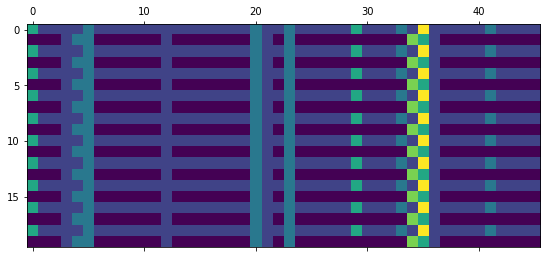

In [29]:
plt.matshow(arr)

## Hashed Morgan Fingerprints

In [36]:
from molvecgen.vectorizers import HashedMorganVectorizer

In [37]:
hmv = HashedMorganVectorizer(bits=200)

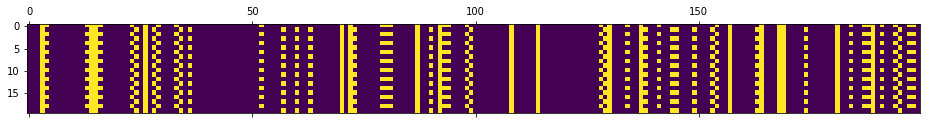

In [38]:
plt.matshow(hmv.transform(mols))